# Predicting the Presence or Absense of Heart Disease

## Introduction

Cardiovascular diseases, including heart disease, stand as one of the primary global causes of mortality. Timely diagnosis and intervention are pivotal in enhancing patient outcomes. To tackle this issue, we propose a project centered around utilizing a dataset encompassing relevant medical attributes to predict the likelihood of heart disease presence or absence in patients.

This project seeks to answer the question:
**Given the 14 selected attributes in the dataset, could we determine whether there is a presence or absence of heart disease of a new patient?**
 
The dataset was obtained from Kaggle, which contains data dating back to 1988. We’ve decided to choose a dataset that combines data from Cleveland, Hungary, Switzerland, and Long Beach V to get a wider sense of observations. There are a total of 76 attributes but filtered down to 14, including the predictive attribute, which in this case is whether or not the patient has heart disease. This binary outcome variable is represented as 0 (no disease) or 1 (disease).


## Preliminary Exploratory Data Analysis

In [1]:
### Run this cell before continuing.
install.packages("cowplot") ### Only run this once 
install.packages("kknn")
library(cowplot)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::di

In [2]:
# Load in dataset
heart_data <- read_csv("https://raw.githubusercontent.com/random56428/heart-disease/main/data/heart.csv")
# Mutate target variable into factors
heart_data <- mutate(heart_data, target = as_factor(target))
# Peek the first 6 rows of the dataset
head(heart_data)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


Table 1: First 6 rows of the heart disease data set

In [3]:
# Set the seed. Don't remove this!
set.seed(2023)

# Randomly split 75% of the data in the training set
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# heart_split
# heart_train
# heart_test

By using a proportion of 0.75 as the data split, we are splitting 75% of the data into the training data set and the rest into the testing data set. This way, we're able to balance the variance between the parameter estimates and statistics in training and testing data sets.

In [4]:
# Table that reports the number of observations in each class (target) of the training dataset
heart_train |>
    group_by(target) |>
    summarize(count = n())

target,count
<fct>,<int>
0,374
1,394


Table 2. The patient counts for heart disease (0 = no disease, 1 = disease)

In [5]:
# Means of the predictor variables
heart_train |>
    select(-target) |>
    summarize(across(everything(), ~ mean(.x, na.rm = TRUE))) |>
    rename_with(~ paste0(., "_mean"))

age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,fbs_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean,ca_mean,thal_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.39583,0.6953125,0.9335938,131.513,246.2227,0.1458333,0.5351562,148.9818,0.3398438,1.055599,1.388021,0.7330729,2.33724


Table 3. The means for every predictor

In [6]:
# Amount of cells with missing data
sum(is.na(heart_train))

[1] 0

The kaggle data set contains 0 missing data cells.

### Comparison of the distributions of each of the predictor variables

In [7]:
# Set width and height of plot
# Generic function to visualize a distribution of a variable in heart_train
#
# @param type - "bar" for geom_bar, "hist" for geom_histogram
# @param variable_name - name of column header - must be in heart_train
# @param x_label - x-axis label
# @param y_label - y-axis label
# @param title - title of the plot
# @param rename_x_labels_to - a vector of strings to rename x labels to
visualize_dist <- function(type, variable_name, x_label, y_label, title, rename_x_labels_to = NULL, figure_caption) {
    # Throw error if variable name does not exist
    if (!(variable_name %in% colnames(heart_train))) {
        stop(variable_name, " not in any of the dataset headers")
    }
    
    # Create a generic table count of variable_name
    count_table <- heart_train |>
        select(contains(variable_name)) |>
        group_by(across(all_of(variable_name))) |>
        summarize(count = n())
    
    # Set type of plot, aesthetics, and table reference
    geom_type <- NULL
    custom_aes <- NULL
    tbl_ref <- NULL
    rename_x_labels <- NULL # Only used for bar plots
    if (type == "bar") {
        geom_type <- geom_bar(stat = "identity", fill = "#78a9f8", color = "black", linewidth = 0.2)
        custom_aes <- aes(x = factor(get(variable_name)), y = count)
        tbl_ref <- count_table
        rename_x_labels <- if (!is.null(rename_x_labels_to)) scale_x_discrete(labels = rename_x_labels_to)
    } else if (type == "hist") {
        geom_type <- geom_histogram(binwidth = 2, fill = "#78a9f8", color = "black", linewidth = 0.2)
        custom_aes <- custom_aes <- aes(x = get(variable_name))
        tbl_ref <- heart_train
    } else {
        stop(type, " geom type not supported")
    }
    
    # Credit for wrapper: https://stackoverflow.com/a/3935429
    wrapper <- function(x, ...) {
        paste(strwrap(x, ...), collapse = "\n")
    }
    
    # Visualize
    res <- ggplot(tbl_ref, custom_aes) +
        geom_type + 
        labs(x = wrapper(x_label, width = 45), y = y_label, title = wrapper(title, width = 45), caption = figure_caption) +
        theme(text = element_text(size = 10), plot.caption = element_text(hjust = 0.5, size = 11)) + 
        rename_x_labels
    return(res)
}

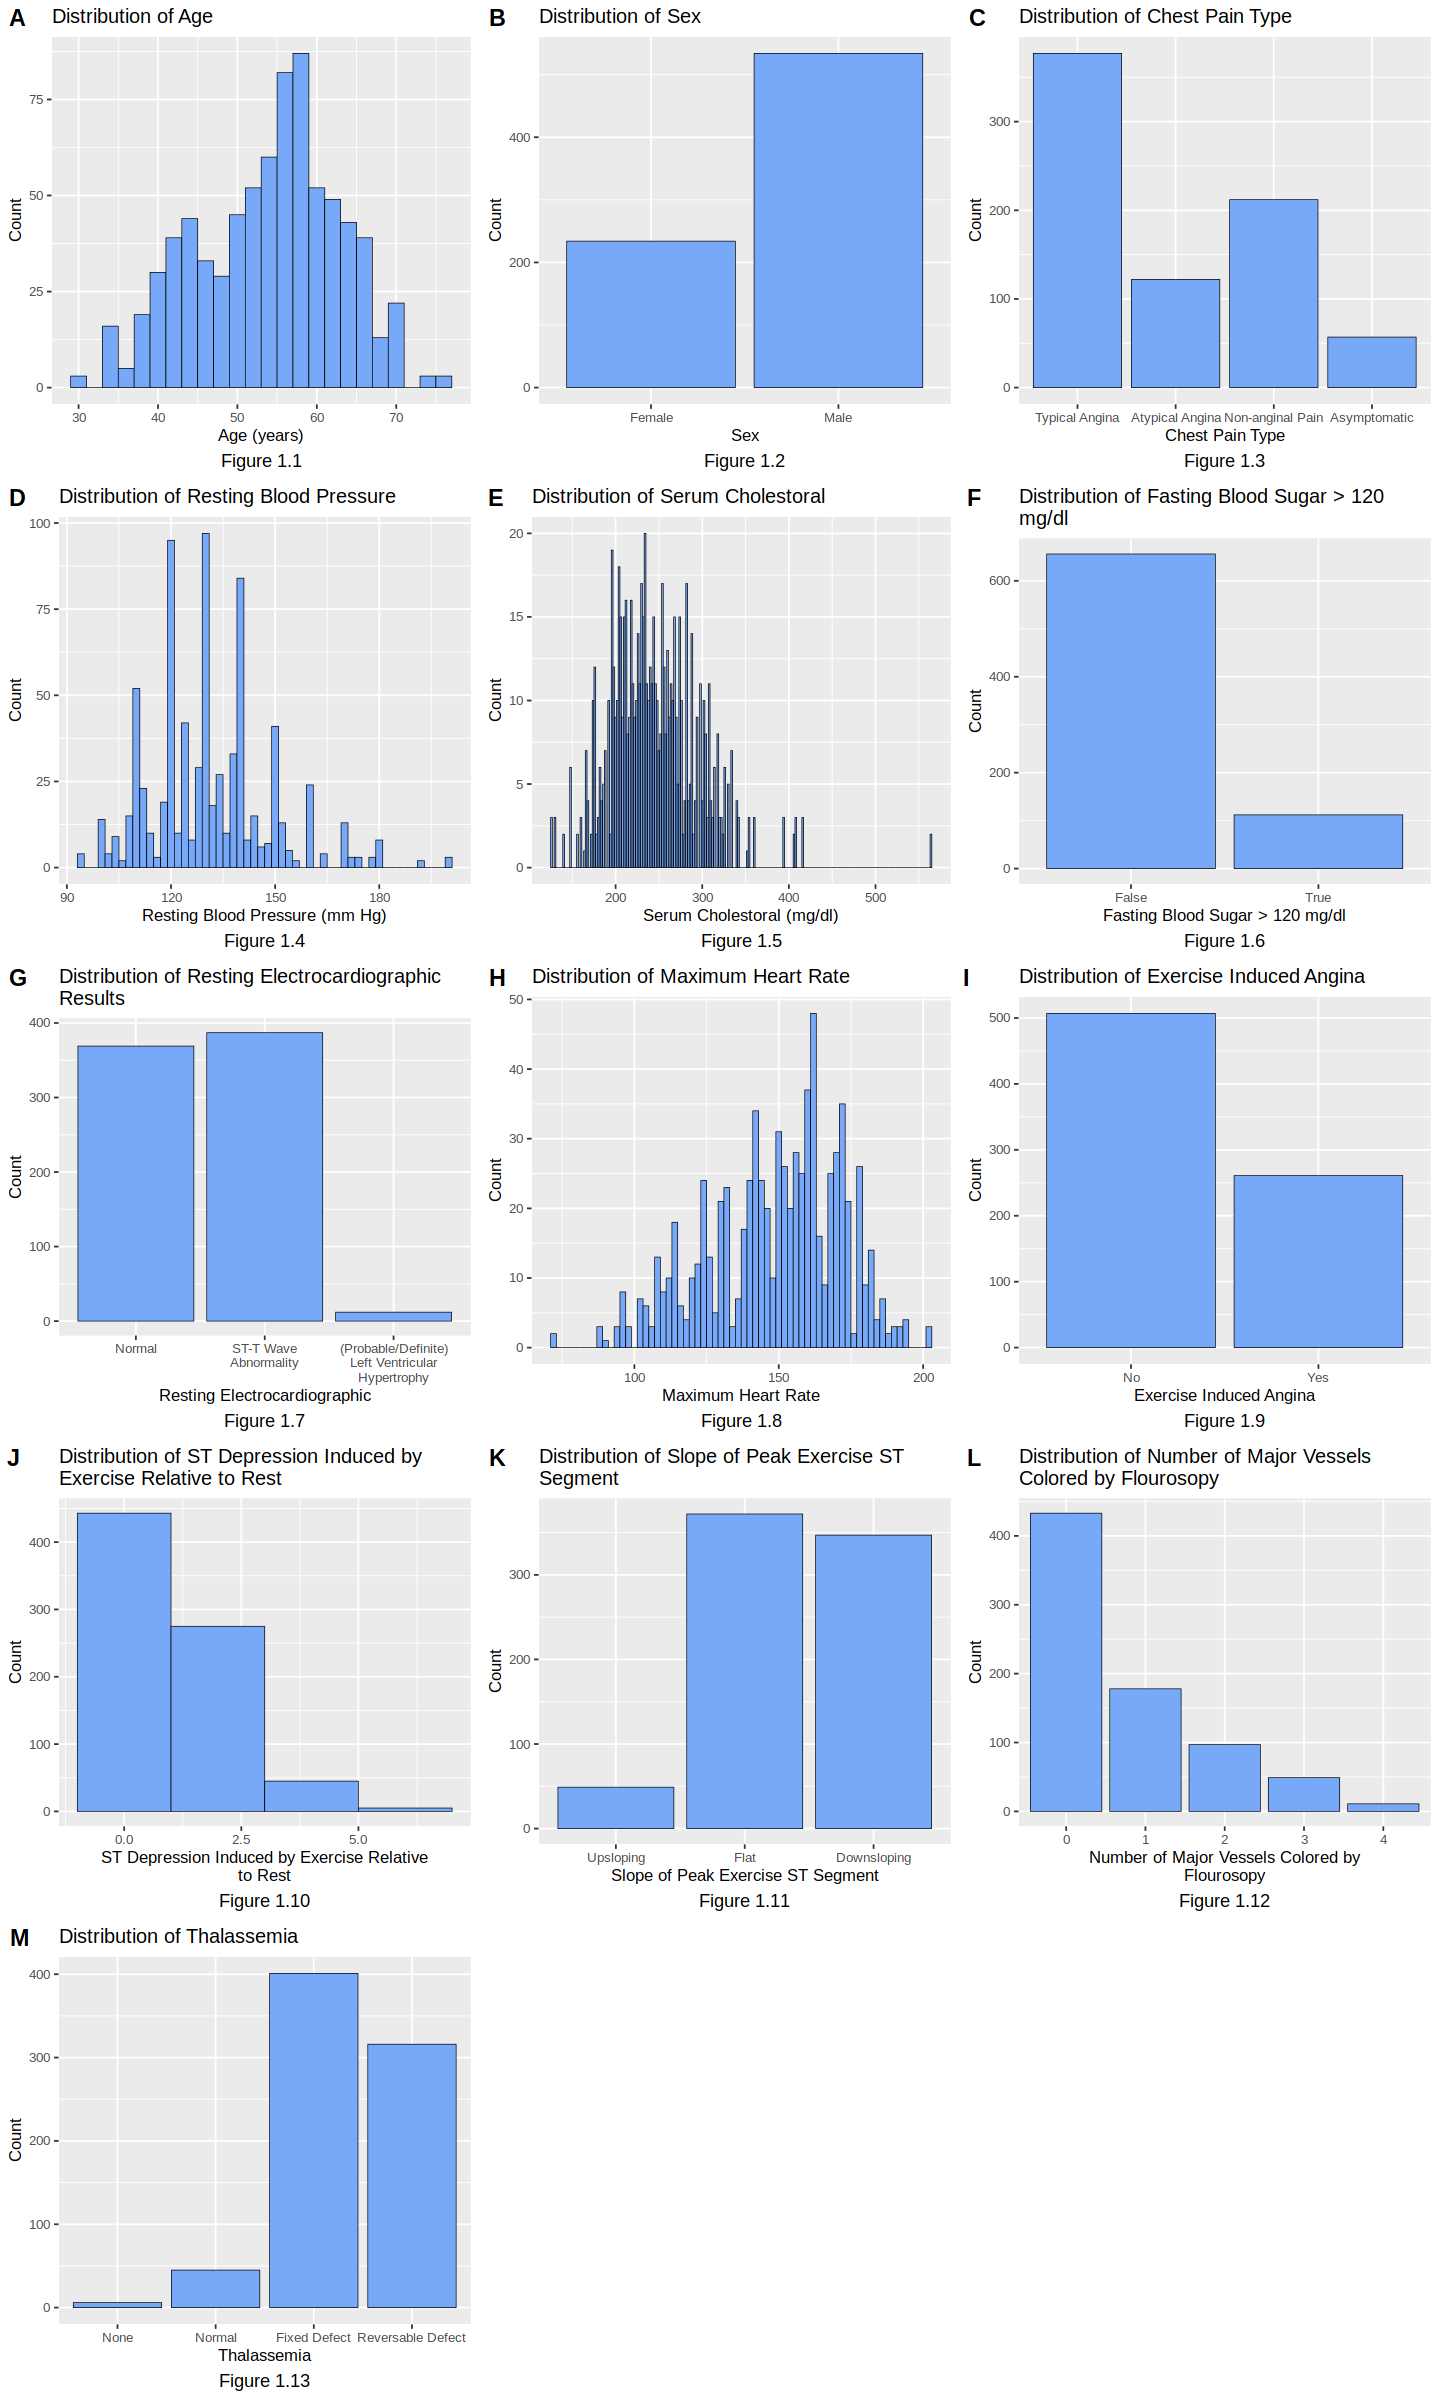

In [8]:
options(repr.plot.width = 12, repr.plot.height = 20)

plot1 <- visualize_dist("hist", "age", "Age (years)", "Count", "Distribution of Age", figure_caption = "Figure 1.1")
plot2 <- visualize_dist("bar", "sex", "Sex", "Count", "Distribution of Sex", c("Female", "Male"), figure_caption = "Figure 1.2")
plot3 <- visualize_dist("bar", "cp", "Chest Pain Type", "Count", "Distribution of Chest Pain Type", c("Typical Angina", "Atypical Angina", "Non-anginal Pain", "Asymptomatic"), figure_caption = "Figure 1.3")
plot4 <- visualize_dist("hist", "trestbps", "Resting Blood Pressure (mm Hg)", "Count", "Distribution of Resting Blood Pressure", figure_caption = "Figure 1.4")
plot5 <- visualize_dist("hist", "chol", "Serum Cholestoral (mg/dl)", "Count", "Distribution of Serum Cholestoral", figure_caption = "Figure 1.5")
plot6 <- visualize_dist("bar", "fbs", "Fasting Blood Sugar > 120 mg/dl", "Count", "Distribution of Fasting Blood Sugar > 120 mg/dl", c("False", "True"), figure_caption = "Figure 1.6")
plot7 <- visualize_dist("bar", "restecg", "Resting Electrocardiographic", "Count", "Distribution of Resting Electrocardiographic Results", c("Normal", "ST-T Wave\nAbnormality", "(Probable/Definite)\nLeft Ventricular\nHypertrophy"), figure_caption = "Figure 1.7")
plot8 <- visualize_dist("hist", "thalach", "Maximum Heart Rate", "Count", "Distribution of Maximum Heart Rate", figure_caption = "Figure 1.8")
plot9 <- visualize_dist("bar", "exang", "Exercise Induced Angina", "Count", "Distribution of Exercise Induced Angina", c("No", "Yes"), figure_caption = "Figure 1.9")
plot10 <- visualize_dist("hist", "oldpeak", "ST Depression Induced by Exercise Relative to Rest", "Count", "Distribution of ST Depression Induced by Exercise Relative to Rest", figure_caption = "Figure 1.10")
plot11 <- visualize_dist("bar", "slope", "Slope of Peak Exercise ST Segment", "Count", "Distribution of Slope of Peak Exercise ST Segment", c("Upsloping", "Flat", "Downsloping"), figure_caption = "Figure 1.11")
plot12 <- visualize_dist("bar", "ca", "Number of Major Vessels Colored by Flourosopy", "Count", "Distribution of Number of Major Vessels Colored by Flourosopy", figure_caption = "Figure 1.12")
plot13 <- visualize_dist("bar", "thal", "Thalassemia", "Count", "Distribution of Thalassemia", c("None", "Normal", "Fixed Defect", "Reversable Defect"), figure_caption = "Figure 1.13")
plot_grid(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10, plot11, plot12, plot13, labels = "AUTO", ncol = 3)

#### Interpretations of visualizations
- A. Figure 1.1 - The histogram is uni-modal with one peak and the mean age is at around 55 to 60 years.
- B. Figure 1.2 - The bar graph shows that there are more data for males than females, at around ~300 more.
- C. Figure 1.3 - There are 4 types of chest pain (typical angina, atypical angina, non-anginal pain, and asymptomatic), with counts of patients being highest for typical angima and lowest for asymptomatic
- D. Figure 1.4 - The distribution of resting blood pressure is right skewed.
- E. Figure 1.5 - The distribution of resting blood pressure is right skewed such that there are a few outliers with high serum cholestoral (> 550 mg/dl) and majority with serum at around the range of 200-300.
- F. Figure 1.6 - Around 600 patients patients do not have fasting blood sugar and around 100 do.
- G. Figure 1.7 - The number of patients are almost the same with normal resting electrocardiographic results and ST-T wave abnormality, whereas a few have left ventricular hypertrophy.
- H. Figure 1.8 - The maximum heart rate is left skewed with more patients have heart rate of 125 - 175.
- I. Figure 1.9 - Around 500 patients do not have exercise induced angina where around 250 do.
- J. Figure 1.10 - Distribution is right skewed, most patients have a 0 st depression induced by exercise relative to rest.
- K. Figure 1.11 - Flat has around 360 slope of peak exercise, downsloping has around 340, and upsloping has around 60.
- L. Figure 1.12 - The bar graph shows a decreasing trend such that around 400 patients have 0 major vessels, 150 patients have 1 major vessel, and so on.
- M. Figure 1.13 - The bar graph shows that most patients have fixed defect, followed by reversable defect and only a few normal/none relatively.


## Methods

To answer the stated question, we will be using the Kaggle heart disease dataset sourced from (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/) which is based on UCI Machine Learning Repository. We will be using Jupyter Notebook and R to analyze this dataset, starting by importing it using the `read_csv()` function from a remote url.

We will begin with data preprocessing, such as checking the dataset for missing values, ensuring the data is clean, and necessary scaling and centering. The feature “target” will be converted to a categorical variable, as this is our target variable. Then, exploratory data analysis (EDA) will be conducted to gain insights into the dataset, such as distribution of variables and relationships among them.

We will be using 14 out of the 76 attributes contained in the dataset, as they are used in all published experiments and seem most relevant for prediction of heart disease. Features 1-13 will be used as predictors, while feature 14 (target - diagnosis of heart disease) will be used as the target variable (what we are aiming to predict for a new observation):
1. `age`
2. `sex` – (female, male)
3. `cp` – chest pain type (typical angina, atypical angina, non-anginal pain, asymptomatic)
4. `trestbps` – resting blood pressure (in mm Hg on admission to the hospital)
5. `chol` – serum cholesterol (mg/dl)
6. `fbs` – fasting blood sugar > 120 mg/dl (0 = false, 1 = true)
7. `restecg` – resting electrocardiographic results (normal, having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), showing probable or definite left ventricular hypertrophy by Estes' criteria)
8. `thalach` – maximum heart rate achieved
9. `exang` – exercise induced angina (0 = no, 1 = yes)
10. `oldpeak` – ST depression induced by exercise relative to rest
11. `slope` – the slope of the peak exercise ST segment (upsloping, flat, downsloping)
12. `ca` – number of major vessels colored by fluoroscopy (0-3)
13. `thal` – thalassemia (0 = none, 1 = normal, 2 = fixed defect, 3 = reversible defect)
14. `target` – diagnosis of heart disease	

We chose to use a K-NN classification algorithm for this analysis, as the nature of our target variable is categorical. We will be visualizing our results using a confusion matrix and plots to visualize the accuracies of various values of K.


## Expected Outcomes and Significance

We expect that the K-NN classification algorithm will predict whether a patient has heart disease or not, and then visualize our findings through confusion matrices and visualization, which will make our assessment more intuitive. We will evaluate the accuracy, precision, and recall of the model to determine whether it can be used in a real-life diagnosis scenario.

By studying our dataset, healthcare providers and clinicians can use our methods to assess whether a patient has heart disease and make informed choices about prevention and treatment. Early identification and timely intervention can save lives and reduce stress on the healthcare system.

What future questions could this lead to?
1. What additional data sources/features can be harnessed to enhance the precision of the data analysis?
2. Does the data analysis reveal divergent performance across various demographic groups?
3. How can the data analysis be extended and enhanced to predict the degree of severity in heart disease?


## Data Analysis

Let's first create a recipe that uses all predictors with scaling and centering.

In [9]:
# Set the seed. Don't remove this!
set.seed(1234567890)

options(repr.plot.height = 5, repr.plot.width = 6)

recipe <- recipe(target ~ ., data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         13

Operations:

Scaling for all_predictors()
Centering for all_predictors()

We will then create a specification to tune the number of neighbors, K. For our cross validation, we use a fold of 5 on the training set.

In [10]:
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
spec

vfold <- vfold_cv(heart_train, v = 5, strata = target)
# vfold

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Create our model with k from 1 to 30 to find the best k. Then collect the metrics from the workflow.

In [11]:
gridvals <- tibble(neighbors = seq(1, 30))
# gridvals

results <- workflow() |>
    add_recipe(recipe) |>
    add_model(spec) |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics()
results

accuracies <- results |>
    filter(.metric == "accuracy")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9765721,5,0.008360485,Preprocessor1_Model01
1,roc_auc,binary,0.9764239,5,0.008601865,Preprocessor1_Model01
2,accuracy,binary,0.9765721,5,0.008360485,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,binary,0.9171533,5,0.009133997,Preprocessor1_Model29
30,accuracy,binary,0.8203178,5,0.009053105,Preprocessor1_Model30
30,roc_auc,binary,0.9203379,5,0.008696266,Preprocessor1_Model30


Table 4. Metrics collected from the workflow analysis for neighbors 1 to 30

Finally, we will plot the accuracy vs. K value to find the best neighbors with highest accuracy.

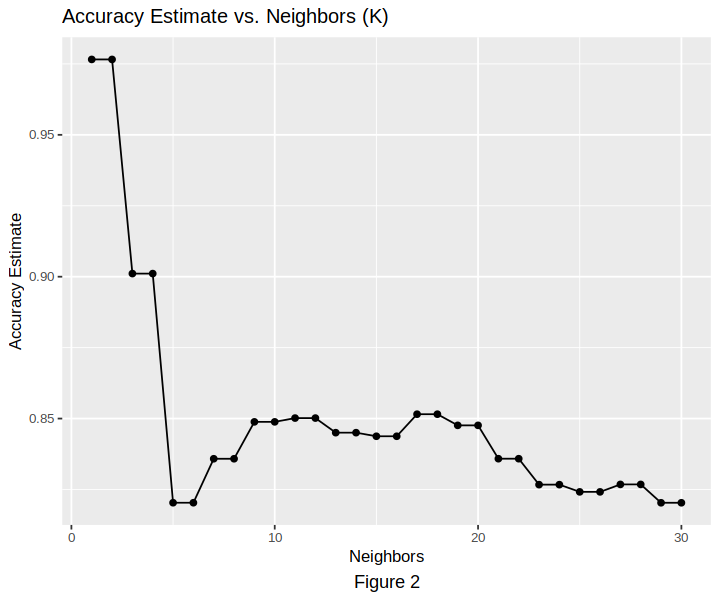

In [12]:
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 2") +
    ggtitle("Accuracy Estimate vs. Neighbors (K)") +
    theme(text = element_text(size = 10), plot.caption = element_text(hjust = 0.5, size = 11))
cross_val_plot

Based on Figure 2, we could either choose `k=1` or `k=2` as they have the highest accuracy (peak) whereas the other neighbors have low accuracy estimates.

In this project, we choose `k=2` to build our final model. We create a specification with the best K as 2, then fit the training set

In [13]:
best_K <- 2
spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K) |>
    set_engine("kknn") |>
    set_mode("classification")

fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(spec2) |>
    fit(heart_train)
fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.03645833
Best kernel: rectangular
Best k: 2

Predict the diagnosis of heart disease, target, using the fit created previously on the testing set.

In [14]:
predictions <- predict(fit, heart_test) |>
    bind_cols(heart_test)
predictions

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
0,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
0,51,1,0,140,298,0,1,122,1,4.2,1,3,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,58,1,0,128,216,0,0,131,1,2.2,1,3,3,0
1,47,1,0,112,204,0,1,143,0,0.1,2,0,2,1
1,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1


Table 5. Table of initial testing set with predicted class binded as a column.

We can check how accurate our predictions where with metrics.

In [15]:
metrics <- predictions |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy")
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9883268


Table 6. Metrics of `k=2` with an accuracy of 98.8%

In [16]:
heart_conf_mat <- conf_mat(data = predictions, truth = target, estimate = .pred_class)
heart_conf_mat

          Truth
Prediction   0   1
         0 122   0
         1   3 132

Table 7. Confusion matrix of the predictions vs. truth of diagnosis of heart disease (target)

Using the confusion matrix, we can calculate the precision and recall. Assume that predicting target correctly is a positive prediction

In [17]:
# Precision = number of correct positive predictions / total number of positive predictions
precision <- 132 / (132 + 3)

# Recall = number of correct positive predictions / total number of positive test set observations
recall <- 132 / (132 + 0)

print(paste("Precision =", precision))
print(paste("Recall =", recall))

[1] "Precision = 0.977777777777778"
[1] "Recall = 1"


The precision and recall are relatively high, using the 13 predictors, we are able to identify diagnosis of heart disease with this model. However, with only `k=2` neighbors, we are unsure of whether there is overfitting or not, so we would do further testing with a 50 to 50 split.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9647642,5,0.01071176,Preprocessor1_Model01
2,accuracy,binary,0.9647642,5,0.01071176,Preprocessor1_Model02
3,accuracy,binary,0.8867054,5,0.01138950,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.8269481,5,0.01210042,Preprocessor1_Model28
29,accuracy,binary,0.8204375,5,0.01371771,Preprocessor1_Model29
30,accuracy,binary,0.8204375,5,0.01371771,Preprocessor1_Model30


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9883268


          Truth
Prediction   0   1
         0 122   0
         1   3 132

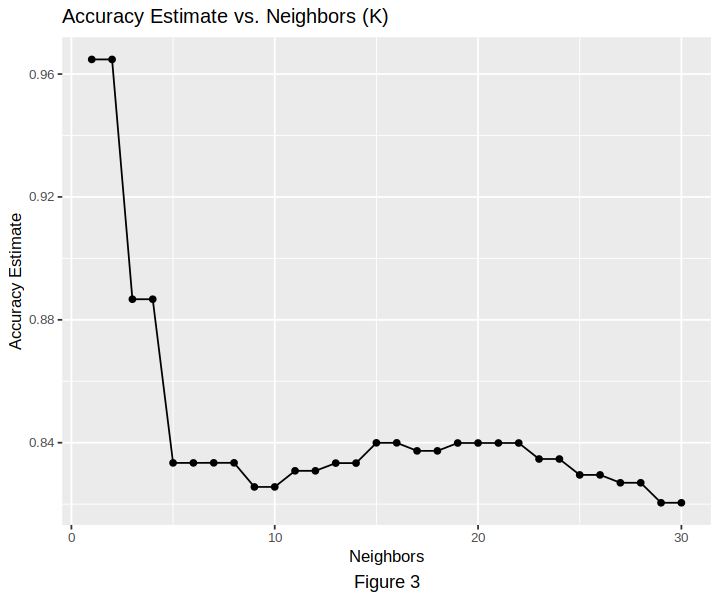

In [18]:
set.seed(2023)

# Randomly split 50% of the data in the training set
heart_split_50 <- initial_split(heart_data, prop = 0.50, strata = target)
heart_train_50 <- training(heart_split)
heart_test_50 <- testing(heart_split)

recipe_50 <- recipe(target ~ ., data = heart_train_50) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

spec_50 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold_50 <- vfold_cv(heart_train_50, v = 5, strata = target)

results_50 <- workflow() |>
    add_recipe(recipe_50) |>
    add_model(spec_50) |>
    tune_grid(resamples = vfold_50, grid = gridvals) |>
    collect_metrics()

accuracies_50 <- results_50 |>
    filter(.metric == "accuracy")
accuracies_50

cross_val_plot_50 <- accuracies_50 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 3") +
    ggtitle("Accuracy Estimate vs. Neighbors (K)") +
    theme(text = element_text(size = 10), plot.caption = element_text(hjust = 0.5, size = 11))
cross_val_plot_50

best_K <- 2
spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K) |>
    set_engine("kknn") |>
    set_mode("classification")

fit_50 <- workflow() |>
    add_recipe(recipe_50) |>
    add_model(spec2) |>
    fit(heart_train_50)

predictions_50 <- predict(fit_50, heart_test_50) |>
    bind_cols(heart_test_50)

metrics_50 <- predictions_50 |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy")
metrics_50

heart_conf_mat_50 <- conf_mat(data = predictions_50, truth = target, estimate = .pred_class)
heart_conf_mat_50


In [19]:
set.seed(2023)

predictor_accuracies <- tibble(predictor = character(), accuracy = numeric())

headers <- heart_data |> 
    select(-target) |>
    colnames()

heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

best_K <- 2
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(heart_train, v = 5, strata = target)

# cross_val_plot <- accuracies |>
#     ggplot(aes(x = neighbors, y = mean)) +
#     geom_point() + 
#     geom_line() + 
#     labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 2") +
#     ggtitle("Accuracy Estimate vs. Neighbors (K)") +
#     theme(text = element_text(size = 10), plot.caption = element_text(hjust = 0.5, size = 11))
# cross_val_plot

for (header in headers) {
    recipe <- recipe(formula(paste("target ~", header)), data = heart_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())
    
    fit <- workflow() |>
        add_recipe(recipe) |>
        add_model(spec) |>
        fit(heart_train)
    
    predictions <- predict(fit, heart_test) |>
        bind_cols(heart_test)
    
    estimate <- predictions |>
        metrics(truth = target, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        pull(.estimate)

    predictor_accuracies <- add_row(predictor_accuracies, predictor = header, accuracy = estimate)
}

predictor_accuracies |> 
    arrange(desc(accuracy)) |> 
    print(n=Inf)

# A tibble: 13 × 2
   predictor accuracy
   <chr>        <dbl>
 1 chol         0.770
 2 thalach      0.603
 3 trestbps     0.545
 4 age          0.514
 5 oldpeak      0.510
 6 sex          0.486
 7 cp           0.486
 8 fbs          0.486
 9 restecg      0.486
10 exang        0.486
11 slope        0.486
12 ca           0.486
13 thal         0.486


## Discussion

## References